## In what ways has social media contributed to the growth and visibility of the Fridays for Future climate movement?


In [ ]:
import pandas as pd
from googleapiclient.discovery import build
from collections import OrderedDict
from collections import Counter

api_key = ""
youtube = build("youtube", "v3", developerKey= api_key)


def flatten(xss):
    ''' function that flattens one list
       i: list in list
       o: list'''
    return [x for xs in xss for x in xs]


def search_video(before=None, after=None, filename="input.csv"):
    '''searches youtube videos with given parameters
       and saves them as a csv'''
    all_videos = []
    next_page_token = None
    max_pages = 2
    current_page = 0

    while current_page < max_pages:
        parameters = {
            "q": "Friday for Future",
            "maxResults": 50,
            "part": "snippet",
            "order": "relevance",
            "type": "video",
            "relevanceLanguage":"de",
            "videoCategoryId": "25" # Politics and news
        }
        if before is not None:
            parameters["publishedBefore"] = before
        if after is not None:
            parameters["publishedAfter"] = after
        if next_page_token:
            parameters["pageToken"] = next_page_token

        request = youtube.search().list(**parameters)
        response = request.execute()
        all_videos.extend(response["items"])

        next_page_token = response.get("nextPageToken")
        current_page += 1

    # List of video ids
    ids = []
    for item in all_videos:
        ids.append(item["id"]["videoId"])
    titles = []
    for item in all_videos:
        titles.append(item["snippet"]["title"])


    # getting comments for each video
    all_comments = []
    for videoid in ids:
        video_comments = []
        try:
            request = youtube.commentThreads().list(
                part="snippet",
                videoId=videoid,
                maxResults=10,
                textFormat="plainText",
                order="relevance"
            )
            response = request.execute()
            for c in response.get("items", []):
                video_comments.append(c["snippet"]["topLevelComment"]["snippet"]["textDisplay"])

        # Comments may be disabled
        except Exception as e:
            continue

        all_comments.append(video_comments)
        
    descriptions =[]
    for video_id in ids:
        try:
            request = youtube.videos().list(
                part="snippet",
                id=video_id
        )
            response = request.execute()
            for item in response.get("items", []):
                description = item["snippet"].get("description", "")
                descriptions.append(description)

        except Exception as e:
             continue

    comments = flatten(all_comments)
    final_data = titles + comments 
    df = pd.DataFrame(final_data, columns=["text"])
    df.to_csv(filename, index=False, encoding="utf-8")
    return ids, final_data


In [30]:
def video_count(video_list, counts="numbers.csv", sorted_count="sorted.csv"):
    '''Counts the amount of videos per each day 
       and sorts videos by view count'''
    df = pd.DataFrame(video_list)
    df["upload time"] = pd.to_datetime(df["upload time"])

    df["year_month_day"] = df["upload time"].dt.to_period("D")

    video_counts = df["year_month_day"].value_counts().sort_index()

    df_counts = video_counts.reset_index()
    df_counts.columns = ["year_month_day", "video_count"]
    df_counts.to_csv(counts, encoding="utf-8", index=False)

    sorted_videos = sorted(video_list, key=lambda x: x["views"], reverse=True)
    df_sorted = pd.DataFrame(sorted_videos)
    df_sorted.to_csv(sorted_count, encoding="utf-8", index=False)
    
    return df_counts, df_sorted


    
def get_data(data_ids):
    '''gets title, views, likes, comments and upload time
       for each video'''
    video_data = []
    for item in data_ids:
        request = youtube.videos().list(
            part="snippet, statistics",
            id=item
        )
        response = request.execute()
    
        for video in response.get("items", []):
            title = video["snippet"].get("title", "")
            stats = video.get("statistics", {})
            views = int(stats.get("viewCount", 0))
            likes = int(stats.get("likeCount", 0))
            comments = int(stats.get("commentCount", 0))
            upload_time = video["snippet"].get("publishedAt", "")
        
            video_data.append({
                "title": title,
                "views": views,
                "likes": likes,
                "comments": comments,
                "upload time": upload_time
            
        })
    return video_data





In [31]:
!python -m spacy download de_core_news_sm

^C
     ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
     ------ --------------------------------- 2.4/14.6 MB 13.6 MB/s eta 0:00:01
     ------------- -------------------------- 5.0/14.6 MB 13.6 MB/s eta 0:00:01
     -------------------- ------------------- 7.6/14.6 MB 12.9 MB/s eta 0:00:01
     --------------------------- ----------- 10.2/14.6 MB 13.1 MB/s eta 0:00:01
     --------------------------------- ----- 12.6/14.6 MB 12.8 MB/s eta 0:00:01
     --------------------------------------  14.4/14.6 MB 12.9 MB/s eta 0:00:01
     ---------------------------------------- 14.6/14.6 MB 11.4 MB/s  0:00:01
[+] Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [46]:
import keybert
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
nlp = spacy.load("de_core_news_sm")
german_stopwords = nlp.Defaults.stop_words

def keywords(data):
    model = keybert.KeyBERT() 
    keywords_list = []
    for item in data:
        # Handles comments being lists
        text = str(item)
        kw_single = model.extract_keywords(text, keyphrase_ngram_range=(1,1))
        keywords_list.extend(kw_single)

# Extract keywords
    ignore_words = ["fridays", "fridays future", "video", "fuß", "sehen", "20", "quot", "mal", "herr", "innen" ]
    all_stopwords = german_stopwords.union(ignore_words)
    flattened_keywords = [kw for kw, score in keywords_list if kw.lower() not in all_stopwords]


# Count frequencies
    keywords_df = pd.DataFrame(Counter(flattened_keywords).items(), columns=["words", "numbers"])
    frequent_words = keywords_df.loc[keywords_df['numbers'] > 3].sort_values(by='numbers', ascending=False)
    frequent_words.to_csv("keywords.csv", index=False, encoding="utf-8")
    print(frequent_words)
    
    wordcloud = WordCloud(background_color="white",
                      width=2500,
                      colormap="winter",    
                      height=1000,
                      scale=2.0,
                      min_font_size=6).fit_words(dict(Counter(flattened_keywords))).to_file('arxiv_word_cloud.png')
    plt.figure(figsize=(15, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()




In [39]:
x,y = search_video("2019-05-01T00:00:00Z", "2019-01-01T00:00:00Z", filename="dataSetTilMay.csv")
x2,y2 = search_video("2020-01-01T00:00:00Z", "2019-05-01T00:00:00Z", filename="dataSetTilJan20.csv")
x3,y3 = search_video("2021-01-01T00:00:00Z", "2020-01-01T00:00:00Z", filename="dataSetTilJan21.csv")


In [ ]:
data1 = get_data(x)
video_count(data1, "data1_num.csv", "data1_sort.csv")
data2 = get_data(x2)
video_count(data2, "data2_num.csv", "data2_sort.csv")
data3 = get_data(x3)
video_count(data3, "data3_num.csv", "data3_sort.csv")


In [41]:
import pandas as pd

# Read the CSVs
df1 = pd.read_csv("data1_num.csv")
df2 = pd.read_csv("data2_num.csv")
df3 = pd.read_csv("data3_num.csv")

df_all = pd.concat([df1, df2, df3], ignore_index=True)
df_all.to_csv("combined.csv", index=False)


In [42]:
full_data = y + y2 + y3


            words  numbers
2          future      131
14           demo       31
26          klima       29
40          greta       27
48    klimaschutz       22
...           ...      ...
936        diesel        4
966    generation        4
994        arbeit        4
1377      siemens        4
1468     schinkel        4

[95 rows x 2 columns]


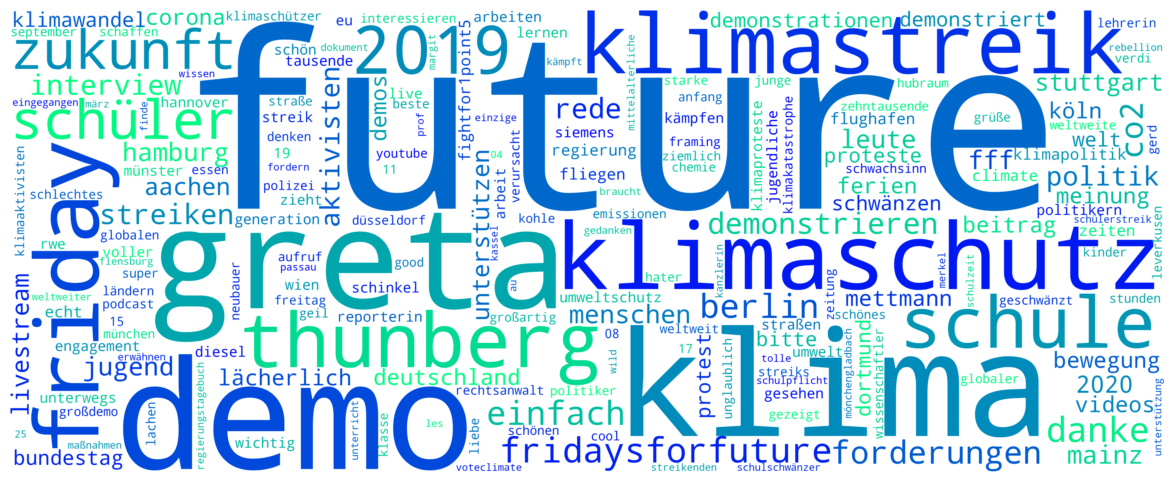

In [47]:
keywords(full_data)

In [44]:
import pandas as pd
from io import StringIO
import requests

url = "https://en.wikipedia.org/wiki/List_of_school_climate_strikes"
headers = {"User-Agent": "Data Science Analytics (Dianer)"}

response = requests.get(url, headers=headers)

tables = pd.read_html(StringIO(response.text))

df = tables[0]
if "Country" in df.columns:
    df_germany = df[df["Country"].str.contains("Germany", na=False)]
columns = ["Date", "Cities", "Participants"]
df_germany = df_germany[columns]
df_germany["Date"] = pd.to_datetime(df_germany["Date"])
df_germany = df_germany[(df_germany["Date"] >= "2019-01-01") & (df_germany["Date"] < "2021-01-01")]
# Save to CSV
df_germany.to_csv("fff_germany_strikes.csv", index=False, encoding="utf-8")
print(df_germany)

          Date                                Cities     Participants
24  2019-01-18                          50 locations            25000
27  2019-01-25                                Berlin            10000
31  2019-02-01                          25 locations            12000
35  2019-02-08                          50 locations            21000
43  2019-02-15                     Over 35 locations            26000
81  2019-03-15        Nationwide, 230 locations[156]           300000
108 2019-03-29               Berlin and other cities            40000
110 2019-04-05  Neubrandenburg, Greifswald, Schwerin             300+
115 2019-04-12               Berlin and other cities            1000+
132 2019-05-11                              Konstanz             500+
139 2019-05-24                            Nationwide           320000
151 2019-06-21                                Aachen  40000[299][300]
152 2019-06-28                                Berlin         500[301]
154 2019-07-05      

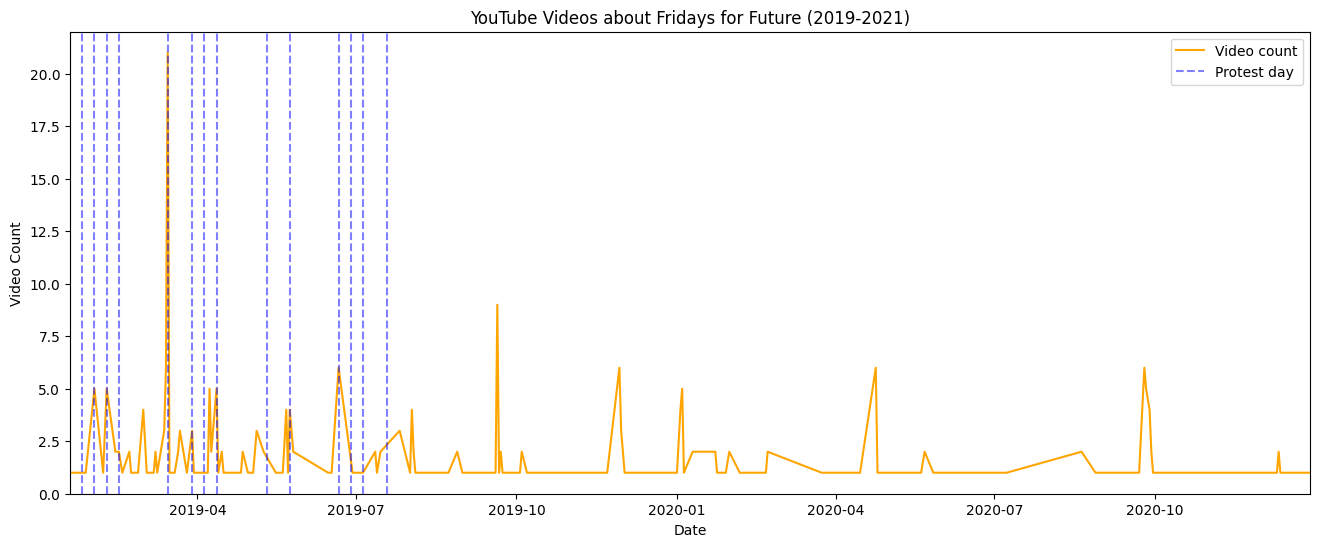

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("combined.csv", parse_dates=["year_month_day"])

df_protests = pd.read_csv("fff_germany_strikes.csv", parse_dates=["Date"])

plt.figure(figsize=(16,6))

plt.plot(df["year_month_day"], df["video_count"], label="Videos per day", color="orange")

for protest_day in df_protests["Date"]:
    plt.axvline(protest_day, color="blue", linestyle="--", alpha=0.5)

plt.xlim(df["year_month_day"].min(), df["year_month_day"].max())
plt.xlabel("Date")
plt.ylabel("Video Count")
plt.title("YouTube Videos about Fridays for Future (2019-2021)")
plt.legend(["Video count", "Protest day"])
plt.show()
